# Description

Сервисы доставки еды уже давно перестали быть просто курьерами, которые привозят заказ. Индустрия e-grocery стремительно идет к аккумулированию и использованию больших данных, чтобы знать о своих пользователях больше и предоставлять более качественные и персонализированные услуги. Одним из шагов к такой персонализации может быть разработка модели, которая понимает привычки и нужды пользователя, и, к примеру, может угадать, что и когда пользователь захочет заказать в следующий раз.

Такая модель, будучи разработанной, может принести значительную ценность для клиента - сэкономить время при сборке корзины, помочь ничего не забыть в заказе, убрать необходимость планировать закупки и следить за заканчивающимися запасами продуктов.

В данном соревновании участникам предлагается решить задачу предсказания следующего заказа пользователя (безотносительно конкретного момента времени, когда этот заказ произойдет). Заказ пользователя состоит из списка уникальных категорий товаров, вне зависимости от того, сколько продуктов каждой категории он взял.

В качестве тренировочных данных представляется датасет с историей заказов 20000 пользователей вплоть до даты отсечки, которая разделяет тренировочные и тестовые данные по времени.

train.csv:
user_id - уникальный id пользователя
order_completed_at - дата заказа
cart - список уникальных категорий (category_id), из которых состоял заказ
В качестве прогноза необходимо для каждой пары пользователь-категория из примера сабмита вернуть 1, если категория будет присутствовать в следующем заказе пользователя, или 0 в ином случае. Список категорий для каждого пользователя примере сабмита - это все категории, которые он когда-либо заказывал.

sample_submission.csv:
Пример сабмита. В тест входят не все пользователи из тренировочных данных, так как некоторые из них так ничего и не заказали после даты отсечки.

id - идентификатор строки - состоит из user_id и category_id, разделенных точкой с запятой: f'{user_id};{category_id}'. Из-за особенностей проверяющей системы Kaggle InClass, использовать колонки user_id, category_id в качестве индекса отдельно невозможно
target - 1 или 0 - будет ли данная категория присутствовать в следующем заказе пользователя

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

Загружаем данные

In [2]:
data = pd.read_csv('train.csv')
sample = pd.read_csv('sample_submission.csv')

## EDA

Взглянем на данные

In [6]:
print(data.head())
print(data.info())

   user_id  order_completed_at  cart
0        2 2015-03-22 09:25:46   399
1        2 2015-03-22 09:25:46    14
2        2 2015-03-22 09:25:46   198
3        2 2015-03-22 09:25:46    88
4        2 2015-03-22 09:25:46   157
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   user_id             int64         
 1   order_completed_at  datetime64[ns]
 2   cart                int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 71.5 MB
None


In [4]:
sample.head()

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0


преобразуем order_completed_at в datetime

In [5]:
data['order_completed_at'] = pd.to_datetime(data['order_completed_at'])

Разделение `user_id` и `category_id` в sample_submission для удобства анализа

In [7]:
submission = sample.copy()

submission['user_id'] = submission['id'].map(lambda x: x.split(';')[0]).astype(int)
submission['cart'] = submission['id'].map(lambda x: x.split(';')[1]).astype(int)

submission = submission[['user_id', 'cart', 'target']]
submission.head()

,user_id,cart,target
0,0,133,0
1,0,5,1
2,0,10,0
3,0,396,1
4,0,14,0


In [9]:
print('Объем датасета:', len(data))
print('Количество пользователей в train.csv:', len(data['user_id'].unique()))
print('Количество пользователей в sample_submission.csv:', len(submission['user_id'].unique()))
print('Количество категорий в train.csv:', len(data['cart'].unique()))
print('Количество категорий в sample_submission.csv:', len(submission['cart'].unique()))

Объем датасета: 3123064
Количество пользователей в train.csv: 20000
Количество пользователей в sample_submission.csv: 13036
Количество категорий в train.csv: 881
Количество категорий в sample_submission.csv: 858


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   user_id             int64         
 1   order_completed_at  datetime64[ns]
 2   cart                int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 71.5 MB


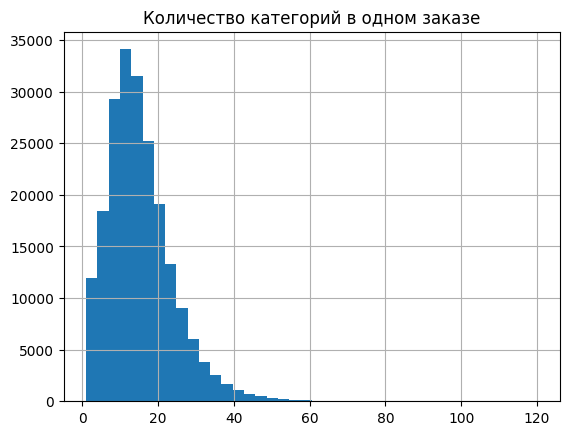

In [11]:
data.groupby(['user_id', 'order_completed_at'])['cart'].count().hist(bins=40)
plt.title('Количество категорий в одном заказе')
plt.show()

In [11]:
data.groupby(['user_id', 'order_completed_at'])['cart'].count().describe()

count    209406.000000
mean         14.913918
std           8.799745
min           1.000000
25%           9.000000
50%          13.000000
75%          19.000000
max         120.000000
Name: cart, dtype: float64

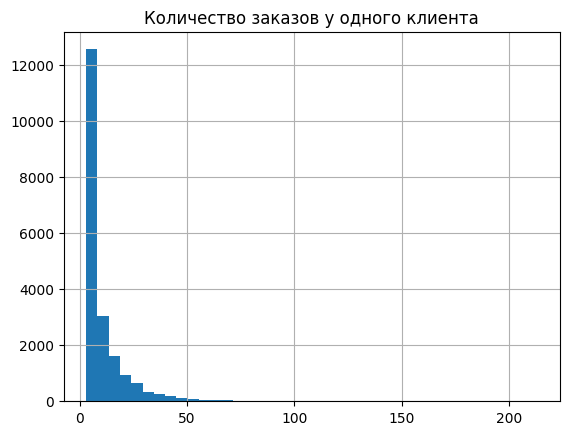

In [12]:
data.groupby('user_id')['order_completed_at'].nunique().hist(bins=40)
plt.title('Количество заказов у одного клиента')
plt.show()

In [13]:
data.groupby('user_id')['order_completed_at'].nunique().describe()

count    20000.000000
mean        10.470300
std         11.905856
min          3.000000
25%          4.000000
50%          6.000000
75%         12.000000
max        213.000000
Name: order_completed_at, dtype: float64

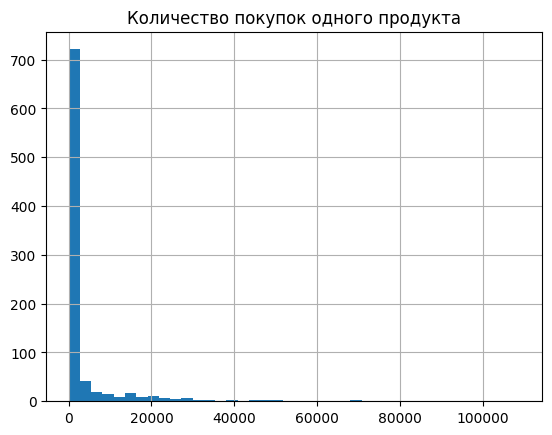

In [14]:
data['count'] = 1

data.groupby(['cart'])['count'].count().hist(bins=40)
plt.title('Количество покупок одного продукта')
plt.show()

In [15]:
data.groupby(['cart'])['count'].count().describe()

count       881.000000
mean       3544.908059
std       10686.317664
min           1.000000
25%           7.000000
50%          66.000000
75%        1101.000000
max      108877.000000
Name: count, dtype: float64

## Гипотезы

Гипотезы:

**Часто ли пользователи повторяют категории?**

Важный сигнал для предсказания будущего заказа.

**Есть ли связь между числом заказов пользователя и количеством уникальных категорий?**

Активные пользователи могут проявлять разные предпочтения.

In [16]:
# Гипотеза 1: Повторяемость категорий
repeated_categories = data.groupby('cart')['user_id'].nunique() / data['user_id'].nunique()
print(repeated_categories.sort_values(ascending=False).head(10))

cart
57     0.84970
14     0.80185
61     0.79750
398    0.76045
23     0.74870
22     0.72740
84     0.71905
383    0.70940
382    0.69690
420    0.67340
Name: user_id, dtype: float64


C:\Users\rusbe\AppData\Local\Temp\ipykernel_27792\473894106.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_categories['category_id'], y=top_10_categories['count'], palette='viridis')


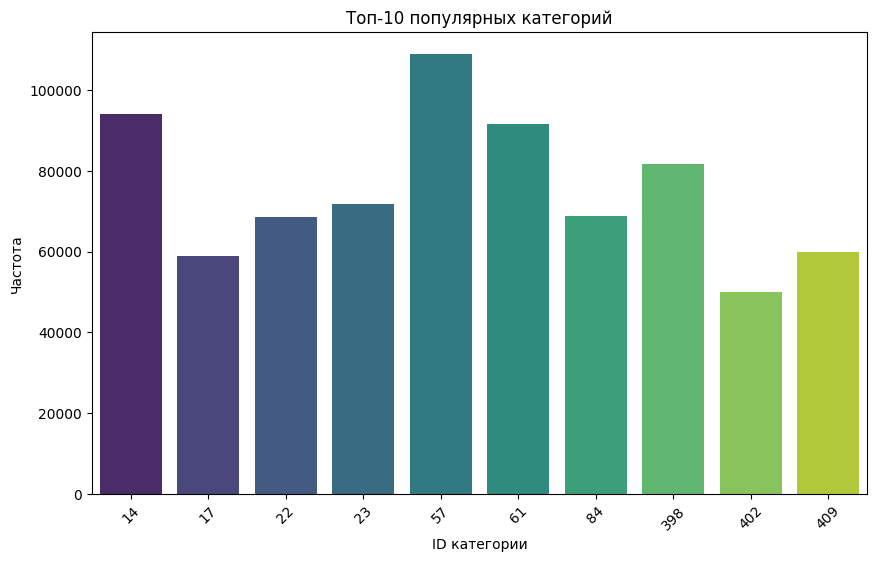

In [17]:
# Подсчет количества заказов каждой категории
category_counts = data['cart'].value_counts().reset_index()
category_counts.columns = ['category_id', 'count']

# Топ-10 популярных категорий
top_10_categories = category_counts.head(10)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_categories['category_id'], y=top_10_categories['count'], palette='viridis')
plt.title('Топ-10 популярных категорий')
plt.xlabel('ID категории')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.show()

Категория с ID 57 была включена в 84.97% заказов. Она может быть базовым "товаром", например хлеб или молоко. Возможно, нужно учитывать общую популярность категории в моделировании.

# Feature engineering

Преобразуем данные для работы с последовательностями заказов

In [19]:
order_dates = data.groupby('user_id')['order_completed_at'].unique()
for i in order_dates.index:
    order_dates.array[i] = sorted(order_dates.array[i])

def get_order_number(args):
    [user, order_date] = args
    return order_dates[int(user)].index(order_date) + 1

In [20]:
data['order_number'] = data[['user_id', 'order_completed_at']].apply(get_order_number, axis=1)
count_orders = pd.DataFrame(data.groupby('user_id')['order_completed_at'].nunique()).reset_index().rename(columns={'order_completed_at': 'orders_count'})
data = pd.merge(data, count_orders, on=['user_id'], how="left")

In [21]:
data['is_last_order'] = data['order_number'] == data['orders_count']
data['is_last_order'] = data['is_last_order'].astype(np.int64)

data.head(5)

,user_id,order_completed_at,cart,count,order_number,orders_count,is_last_order
0,2,2015-03-22 09:25:46,399,1,1,15,0
1,2,2015-03-22 09:25:46,14,1,1,15,0
2,2,2015-03-22 09:25:46,198,1,1,15,0
3,2,2015-03-22 09:25:46,88,1,1,15,0
4,2,2015-03-22 09:25:46,157,1,1,15,0


Разделяем данные на "предыдущие" и "последние" заказы

In [22]:
data_prev = data[data['is_last_order'] == 0].drop(columns=['order_completed_at', 'is_last_order'], axis=1)
data_last = data[data['is_last_order'] == 1].drop(columns=['order_completed_at', 'order_number', 'orders_count', 'count'], axis=1)

In [23]:
data_last.head(5)

,user_id,cart,is_last_order
1775824,12725,57,1
1775825,12725,99,1
1775826,12725,159,1
1775827,12725,420,1
1775828,12725,149,1


In [24]:
data_prev['orders_count'] -= 1
data.drop(columns=['order_completed_at', 'is_last_order'], axis=1, inplace=True)

In [25]:
data_prev.head(5)

,user_id,cart,count,order_number,orders_count
0,2,399,1,1,14
1,2,14,1,1,14
2,2,198,1,1,14
3,2,88,1,1,14
4,2,157,1,1,14


In [26]:
def create_data(X, data):

    #distance_to_last_order - сколько заказов назад пользователь заказывал товар
    data['distance_to_last_order'] = data['orders_count'] - data['order_number']
    distances = pd.DataFrame(data.groupby(['user_id', 'cart'])['distance_to_last_order'].min()).reset_index()
    X = pd.merge(X, distances, on=['user_id', 'cart'], how='left').dropna()
    data.drop(columns='distance_to_last_order', axis=1, inplace=True)

    #mean_order_size - средний размер заказа клиента
    order_size = pd.DataFrame(data.groupby(['user_id', 'order_number'])['count'].count()).reset_index().rename(columns={'count': 'mean_order_size'})
    mean_order_size = pd.DataFrame(round(order_size.groupby('user_id')['mean_order_size'].mean()))
    X = pd.merge(X, mean_order_size, on=['user_id'], how='left').fillna(0)

    #cart_count_all - сколько раз покупали данную категорию
    cart_count_all = pd.DataFrame(data.groupby(['cart'])['count'].count()).reset_index().rename(columns={'count': 'cart_count_all'})
    X = pd.merge(X, cart_count_all, on=['cart'], how='left').fillna(0)

    #cart_count - сколько раз клиент покупал данный товар
    count = pd.DataFrame(data.groupby(['user_id', 'cart'])['count'].count()).reset_index().rename(columns={'count': 'cart_count'})
    X = pd.merge(X, count, on=['user_id', 'cart'], how='left').fillna(0)

    #last_order_with_cart - номер последнего заказа пользователя с данной категорией
    last_order = pd.DataFrame(data.groupby(['user_id', 'cart'])['order_number'].max()).reset_index().rename(columns={'order_number':'last_order_with_cart'})
    X = pd.merge(X, last_order, on=['user_id', 'cart'], how='left').fillna(0)

    return X

In [27]:
X_train = submission.copy()
X_test = submission.copy()

In [28]:
X_train = create_data(X_train, data_prev)
X_test = create_data(X_test, data)

In [29]:
X_train.head(5)

,user_id,cart,target,distance_to_last_order,mean_order_size,cart_count_all,cart_count,last_order_with_cart
0,0,133,0,0.0,16.0,1328,1,2
1,0,5,1,0.0,16.0,27790,1,2
2,0,10,0,0.0,16.0,13307,1,2
3,0,396,1,0.0,16.0,24373,1,2
4,0,14,0,0.0,16.0,85164,2,2


In [30]:
data_prev_orders_count = data_prev.drop(columns=['order_number', 'count'], axis=1)
data_orders_count = data.drop(columns=['order_number', 'count'], axis=1)

data_prev_orders_count = data_prev_orders_count.drop_duplicates()
data_orders_count = data_orders_count.drop_duplicates()

data_orders_count.head(5)

,user_id,cart,orders_count
0,2,399,15
1,2,14,15
2,2,198,15
3,2,88,15
4,2,157,15


Формируем признаки для обучающей выборки

In [31]:
X_train = pd.merge(X_train, data_prev_orders_count, on=['user_id', 'cart'], how='left')
X_test = pd.merge(X_test, data_orders_count, on=['user_id', 'cart'], how='left')

cart_frequency - частота категории в заказах пользователя

In [32]:


X_train['cart_frequency'] = X_train['cart_count'] / X_train['orders_count']
X_test['cart_frequency'] = X_test['cart_count'] / X_test['orders_count']

In [33]:
all_orders_prev = data_prev_orders_count.drop(columns='cart', axis=1).drop_duplicates()
number_of_all_orders_prev = sum(all_orders_prev['orders_count'])

all_orders = data_orders_count.drop(columns='cart', axis=1).drop_duplicates()
number_of_all_orders = sum(all_orders['orders_count'])
number_of_all_orders_prev, number_of_all_orders

(189406, 209406)

In [34]:
X_train['cart_freq_all'] = X_train['cart_count_all'] / number_of_all_orders_prev
X_test['cart_freq_all'] = X_test['cart_count_all'] / number_of_all_orders

In [35]:
X_train.head(5)

,user_id,cart,target,distance_to_last_order,mean_order_size,cart_count_all,cart_count,last_order_with_cart,orders_count,cart_frequency,cart_freq_all
0,0,133,0,0.0,16.0,1328,1,2,2,0.5,0.007011
1,0,5,1,0.0,16.0,27790,1,2,2,0.5,0.146722
2,0,10,0,0.0,16.0,13307,1,2,2,0.5,0.070256
3,0,396,1,0.0,16.0,24373,1,2,2,0.5,0.128681
4,0,14,0,0.0,16.0,85164,2,2,2,1.0,0.449637


In [36]:
y_train = pd.DataFrame(pd.merge(X_train, data_last, on=['user_id', 'cart'], how='left')['is_last_order'].fillna(0).astype(np.int64))

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 5 columns):
 #   Column        Dtype
---  ------        -----
 0   user_id       int64
 1   cart          int64
 2   count         int64
 3   order_number  int64
 4   orders_count  int64
dtypes: int64(5)
memory usage: 119.1 MB


## Обучение моделей

In [40]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
import xgboost as xgb

In [43]:
param = {'n_estimators': [80, 90, 100, 200, 500],
         'max_depth': [10, 12, 15, 20]}
model = GridSearchCV(estimator=xgb.XGBClassifier(learning_rate=0.1), param_grid=param, scoring='f1', cv=3, refit=True)
model.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'max_depth': [10, 12, 15, 20],
                         'n_estimators': [80, 90, 100, 110]},
             scoring='f1')

In [44]:
def optimal_threshold(start, end, delta, model, X, y):
    best_score = 0
    best_threshold = start
    probs = model.predict_proba(X)

    while start <= end:
        predictions = probs[:, 1] > start
        score = f1_score(y, predictions)
        if score > best_score:
            best_score = score
            best_threshold = start
        start += delta
    return best_score, best_threshold

In [45]:
xgb = model.best_estimator_
print(f"Best Params: {model.best_params_}")

Best Params: {'max_depth': 20, 'n_estimators': 80}


In [46]:
score, threshold = optimal_threshold(0.1, 0.8, 0.05, xgb, X_train, y_train)

In [47]:
score, threshold

(0.8868551867295471, 0.35)

In [48]:
probs = model.predict_proba(X_test)

target = probs[:, 1] > threshold

sample['target'] = target
sample['target'] = sample['target'].astype(int)

sample.to_csv('submission.csv', index=False)